<a href="https://colab.research.google.com/github/jbp261/Cifar-10-using-Fully-Connected-DNN/blob/master/EE258_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [2]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
10.6408560276
GPU (s):
1.85254716873
GPU speedup over CPU: 5x


# **Loading of the libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Loading the CIFAR-10 dataset
from keras.datasets import cifar10
from tensorflow import keras
from datetime import datetime

from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
print(tf.__version__)

1.12.0-rc2


Using TensorFlow backend.


# **Data Loading**

In [4]:
#Train test saperation of the dataset
(x_train_unshuffled, y_train_unshuffled), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 66s 0us/step


# **Data Visualization**

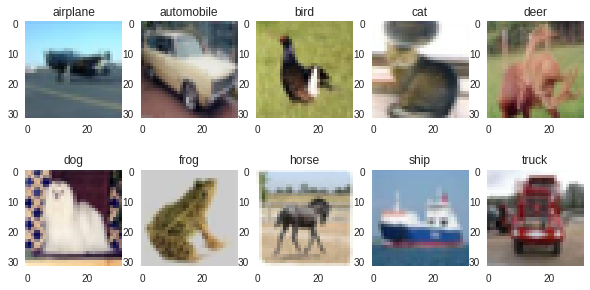

In [5]:
num_classes = 10 # total number of classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 
               'horse', 'ship', 'truck'] # the class names in order

#Visualization of images from each class randomly
fig = plt.figure(figsize=(10,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i)
    idx = np.where(y_train_unshuffled[:]==i)[0]
    features_idx = x_train_unshuffled[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    image = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(image)
    plt.grid(False)
plt.show()

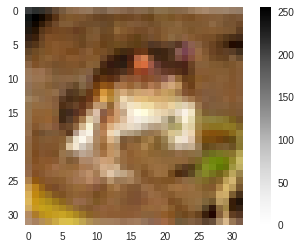

In [6]:
#Visualization of a single image from training data
plt.figure()
plt.imshow(x_train_unshuffled[0])
plt.colorbar()
plt.grid(False)

# **Exploring Train and Test Data**

**Knowing the training data types, dimensions and  distribution**

In [7]:
# Shape of the training and testing data
print('X_train_unshuffled', type(x_train_unshuffled), x_train_unshuffled.shape)
print('X_test', type(X_test), X_test.shape)

('X_train_unshuffled', <type 'numpy.ndarray'>, (50000, 32, 32, 3))
('X_test', <type 'numpy.ndarray'>, (10000, 32, 32, 3))


In [8]:
# Datatypes of the training and testing data
print('X_train_unshuffled element type', type(x_train_unshuffled[1,1,1,1]))
print('X_test element type', type(X_test[1,1,1,1]))

('X_train_unshuffled element type', <type 'numpy.uint8'>)
('X_test element type', <type 'numpy.uint8'>)


In [9]:
#Updating the datatype from uint8 to float32 for training and testing data
x_train_unshuffled = x_train_unshuffled.astype(np.float32)
X_test = X_test.astype(np.float32)
print('X_train_unshuffled element type', type(x_train_unshuffled[1,1,1,1]))
print('X_test element type', type(X_test[1,1,1,1]))

('X_train_unshuffled element type', <type 'numpy.float32'>)
('X_test element type', <type 'numpy.float32'>)


In [10]:
# Shape of the training and testing labels
print('y_train_unshuffled', type(y_train_unshuffled), y_train_unshuffled.shape)
print('y_test', type(y_test), y_test.shape)

('y_train_unshuffled', <type 'numpy.ndarray'>, (50000, 1))
('y_test', <type 'numpy.ndarray'>, (10000, 1))


In [11]:
# Datatype of the training and testing labels
print('y_train_unshuffled element type', type(y_train_unshuffled[1,0]))
print('y_test element type', type(y_test[1,0]))

('y_train_unshuffled element type', <type 'numpy.uint8'>)
('y_test element type', <type 'numpy.int64'>)


In [12]:
#Updating the datatype from uint8 to float32 for training and testing data
y_train_unshuffled = y_train_unshuffled.astype(np.int32)
y_test = y_test.astype(np.int32)
print('y_train_unshuffled element type', type(y_train_unshuffled[1,0]))
print('y_test element type', type(y_test[1,0]))

('y_train_unshuffled element type', <type 'numpy.int32'>)
('y_test element type', <type 'numpy.int32'>)


In [0]:
# Saperating training and validation data and labels with shuffle from unshuffled data and lables
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    x_train_unshuffled, y_train_unshuffled, test_size=0.1, random_state=42)

In [14]:
# Shape of the training and testing data
print('X_train', X_train.shape)
print('X_valid', X_valid.shape)

('X_train', (45000, 32, 32, 3))
('X_valid', (5000, 32, 32, 3))


In [15]:
# Shape of the training and testing labels
print('y_train', y_train.shape)
print('y_valid', y_valid.shape)

('y_train', (45000, 1))
('y_valid', (5000, 1))


**Visualization of the distribution of datapoints among the classes**

In [16]:
# Getting the information on the number of classes and training data points distribution among classes
class_train, counts_train = np.unique(y_train_unshuffled, return_counts = True)
distribution_train = dict(zip(class_train, counts_train))
print(distribution_train )

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


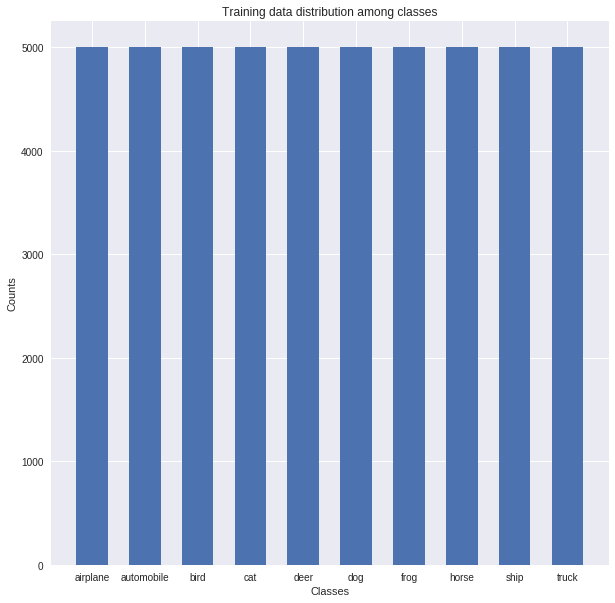

In [17]:
#Plot of the training datapoints distribution among classes
plt.figure(figsize=(10,10))
plt.bar(list(class_names),distribution_train.values(),width =0.6)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Training data distribution among classes')
plt.show()

In [18]:
# Getting the information on the number of classes and testing data points distribution among classes
class_train, counts_train = np.unique(y_test, return_counts = True)
distribution_train = dict(zip(class_train, counts_train))
print(distribution_train )

{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


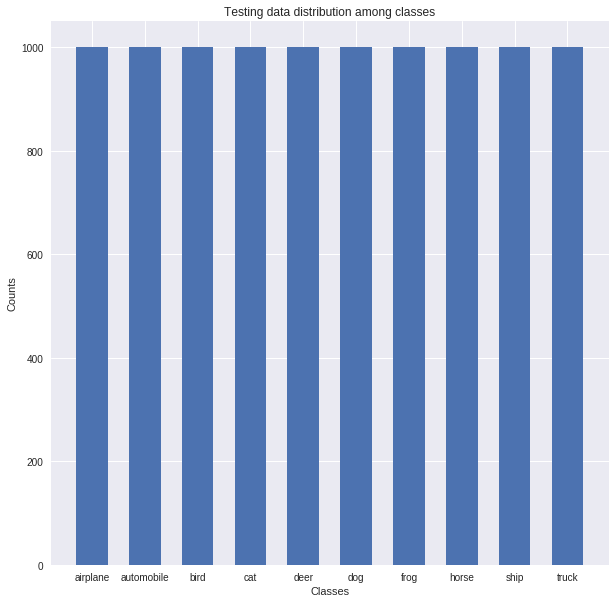

In [19]:
#Plot of the testing datapoints distribution among classes
plt.figure(figsize=(10,10))
plt.bar(list(class_names),distribution_train.values(),width =0.6)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Testing data distribution among classes')
plt.show()

# **Feature Scaling and One Hot Encoding**

In [20]:
# Flattening of the training, testing and validation data
X_train_ft = X_train.flatten().reshape(45000,-1)
X_valid_ft = X_valid.flatten().reshape(5000,-1)
X_test_ft = X_test.flatten().reshape(10000,-1)
# Shape of the flattened training, validation, and testing data
print('X_train_ft', X_train_ft.shape)
print('X_valid_ft', X_valid_ft.shape)
print('X_test_ft', X_test_ft.shape)

('X_train_ft', (45000, 3072))
('X_valid_ft', (5000, 3072))
('X_test_ft', (10000, 3072))


In [0]:
#Scaling the data using Standerd Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#X_train_sc = scaler.fit_transform(X_train)
#X_valid_sc = scaler.fit_transform(X_valid)
#X_test_sc = scaler.fit_transform(X_test)
X_train_ft_sc = scaler.fit_transform(X_train_ft)
X_valid_ft_sc = scaler.fit_transform(X_valid_ft)
X_test_ft_sc = scaler.fit_transform(X_test_ft)

In [0]:
#Scaling the data using Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler_mm = MinMaxScaler()
X_train_ft_mm = scaler_mm.fit_transform(X_train_ft)
X_valid_ft_mm = scaler_mm.fit_transform(X_valid_ft)
X_test_ft_mm = scaler_mm.fit_transform(X_test_ft)

In [0]:
#Need to add one hot encoding here!
#One Hot encoding of the lables
from sklearn.preprocessing import OneHotEncoder
oh_enc = OneHotEncoder()
#y_train_oh = oh_enc.fit_transform(y_train)
#y_valid_oh = oh_enc.fit_transform(y_valid)
#y_test_oh = oh_enc.fit_transform(y_test)

y_train_oh  = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid_oh  = tf.keras.utils.to_categorical(y_valid, num_classes)
y_test_oh  = tf.keras.utils.to_categorical(y_test, num_classes)

# Testing the scaled and unscaled datasets on a generic DNN 

**Performance of Unscaled Data**

In [31]:
#Performance of Unscaled data
batch_size = 50
epoch = len(X_train_ft) /batch_size
lr = 0.001
config = tf.contrib.learn.RunConfig(tf_random_seed=42,
                                   save_checkpoints_steps= 100)
                                   #model_dir="./models/initial/cifar10_init/") 
# set the random seed for tensorflow initializers(for consistency between reruns)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units = [5000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)

#tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr)
#tf.contrib.optimizer_v2.AdadeltaOptimizer(learning_rate=lr,rho=0.95,epsilon=1e-07)

dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # to be compatible with sklearn
dnn_clf.fit(X_train_ft, y_train, batch_size=batch_size, steps=epoch*5)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6c17fb850>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmp8kGbrd', '_tf_random_seed': 42, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp8kGbrd/model.ckpt.
INFO:tensorflow:loss = 164.52156, 

SKCompat()

In [32]:
y_valid_pred = dnn_clf.predict(X_valid_ft)
print(y_valid_pred.keys())
accuracy_score(y_valid, y_valid_pred['classes'])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8kGbrd/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
['probabilities', 'logits', 'classes']


0.301


**Performance of MinMax Scaled data**


In [33]:
#Performance of MinMax Scaled data
batch_size = 50
epoch = len(X_train_ft) /batch_size
lr = 0.001
config = tf.contrib.learn.RunConfig(tf_random_seed=42,
                                   save_checkpoints_steps= 100)
                                   #model_dir="./models/initial/cifar10_init/") 
# set the random seed for tensorflow initializers(for consistency between reruns)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units = [5000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)

#tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr)
#tf.contrib.optimizer_v2.AdadeltaOptimizer(learning_rate=lr,rho=0.95,epsilon=1e-07)

dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # to be compatible with sklearn
dnn_clf.fit(X_train_ft_mm, y_train, batch_size=batch_size, steps=epoch*5)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6c183dd50>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmpyOX5Ya', '_tf_random_seed': 42, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpyOX5Ya/model.ckpt.
INFO:tensorflow:loss = 2.3650155, 

SKCompat()

In [34]:
y_valid_pred = dnn_clf.predict(X_valid_ft_mm)
print(y_valid_pred.keys())
accuracy_score(y_valid, y_valid_pred['classes'])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpyOX5Ya/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
['probabilities', 'logits', 'classes']


0.4156

**Performance of Standerd Sacler Scaled data**

In [35]:
#Performance of Standerd Scaler Scaled data
batch_size = 50
epoch = len(X_train_ft) /batch_size
lr = 0.001
config = tf.contrib.learn.RunConfig(tf_random_seed=42,
                                   save_checkpoints_steps= 100)
                                   #model_dir="./models/initial/cifar10_init/") 
# set the random seed for tensorflow initializers(for consistency between reruns)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_ft)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units = [5000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir=None,
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)

#tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr)
#tf.contrib.optimizer_v2.AdadeltaOptimizer(learning_rate=lr,rho=0.95,epsilon=1e-07)

dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # to be compatible with sklearn
dnn_clf.fit(X_train_ft_sc, y_train, batch_size=batch_size, steps=epoch*5)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6bfaf1a90>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_protocol': None, '_save_checkpoints_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/tmp/tmps8IrdL', '_tf_random_seed': 42, '_master': '', '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_environment': 'local', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmps8IrdL/model.ckpt.
INFO:tensorflow:loss = 2.5555365, 

SKCompat()

In [36]:
y_valid_pred = dnn_clf.predict(X_valid_ft_sc)
print(y_valid_pred.keys())
accuracy_score(y_valid, y_valid_pred['classes'])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmps8IrdL/model.ckpt-4500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
['probabilities', 'logits', 'classes']


0.489

# Using Standard Scaler Scaled Dataset from here:


## Learning Curve (Around 1 epoch)

In [40]:
Train_size_list_1ep = []
Train_error_list_1ep = []
Val_error_list_1ep = []
Train_time_list_1ep = []
Val_time_list_1ep = []
batch_size = 50 # fixed batch size
lr = 0.001 # fixed learning rate
num_epoch = 1 # total number of epoch 

for j in [ 0.999, 0.995, 0.99,0.985,0.98, 0.975,0.97, 0.96,0.95, 0.94, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.2, 0.1, 0.001, 0]:

    #### Data Saperation
    X_train_scaled_partial, X_noneed, y_train_partial, y_noneed  = train_test_split(X_train_ft_sc, 
                                                                                    y_train, test_size = j, 
                                                                                    random_state = 26)
    
    print('Train_set_size:', y_train_partial.shape[0])
    
    Train_size_list_1ep.append(y_train_partial.shape[0])
    
    
    #### Model building
    epoch = len(X_train_scaled_partial) /batch_size # number of steps in one epoch
  
    config = tf.contrib.learn.RunConfig(tf_random_seed=26,
                                   save_checkpoints_steps= 100,
                                   model_dir="./models/dnn_clf_1ep/")
      
    feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_scaled_partial)
    
    dnn_clf_1ep = tf.contrib.learn.DNNClassifier(hidden_units = [5000],
                                          feature_columns=feature_columns,
                                          config=config,
                                          n_classes=num_classes,
                                          activation_fn=tf.nn.relu,
                                          optimizer=tf.contrib.optimizer_v2.AdagradOptimizer(learning_rate=lr),
                                          model_dir="./models/dnn_clf_1ep/",
                                          weight_column_name=None,
                                          dropout=None,
                                          gradient_clip_norm=None,
                                          enable_centered_bias=False,
                                          feature_engineering_fn=None,
                                          embedding_lr_multipliers=None,
                                          input_layer_min_slice_size=None,
                                          label_keys=None)
    
    dnn_clf_1ep = tf.contrib.learn.SKCompat(dnn_clf_1ep) # to be compatible with sklearn
    
    #### Training the model with training data
    start=datetime.now()# Start timing training
    
    dnn_clf_1ep.fit(X_train_scaled_partial, y_train_partial, batch_size=batch_size, steps=num_epoch*epoch) #fit
    
    Train_elapse = (datetime.now()-start).total_seconds() # record timing
    
    Train_time_list_1ep.append(Train_elapse)# apeend training time
    
    y_train_partial_pred = dnn_clf_1ep.predict(X_train_scaled_partial) #return dictionary
    
    Train_error = 1 - accuracy_score(y_train_partial, y_train_partial_pred['classes'])# training error
    
    Train_error_list_1ep.append(Train_error)#append training error
    
    print('dnn_1_clf training time', Train_elapse)
    print(type(y_train_partial_pred))
    
    

    #### Validation of the trained model
    start=datetime.now()# start timing validation prediction
    
    y_val_pred =  dnn_clf_1ep.predict(X_valid_ft_sc) # prediction of validation data
    
    Val_elapse = (datetime.now()-start).total_seconds()# record timing
    
    Val_time_list_1ep.append(Val_elapse)# append validation prediction time
    
    Val_error = 1 - accuracy_score(y_valid, y_val_pred['classes'])#validation error
    
    Val_error_list_1ep.append(Val_error)# append validation error
    
    print('Train error, Val_error',  Train_error, '/', Val_error)
                                   
    
    
    
print("Train_size_list: ", Train_size_list_1ep)
print("Train_error_list: ", Train_error_list_1ep)
print("Val_error_list: ", Val_error_list_1ep)
print("Train_time_list: ", Train_time_list_1ep)
print("Val_time_list: ", Val_time_list_1ep)   

('Train_set_size:', 45)
INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_keep_checkpoint_max': 5, '_task_type': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6bf974dd0>, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': 26, '_device_fn': None, '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_num_ps_replicas': 0, '_train_distribute': None, '_is_chief': True, '_model_dir': './models/dnn_clf_1ep/', '_protocol': None, '_save_checkpoints_steps': 100, '_environment': 'local', '_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/dnn_clf_1ep/model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


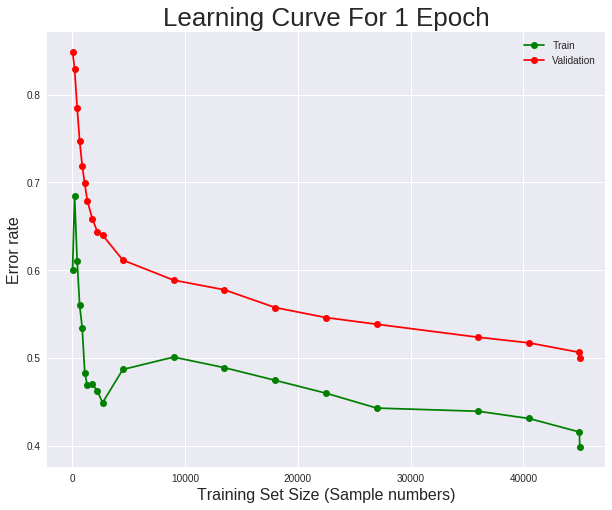

In [46]:
#Drawing learning curve for 1 epoch
plt.figure(figsize = (10,8))
plt.plot(Train_size_list_1ep, Train_error_list_1ep, 'go-',label = "Train")
plt.plot(Train_size_list_1ep, Val_error_list_1ep, 'ro-',label = "Validation")
plt.xlabel('Training Set Size (Sample numbers)',fontsize=16)
plt.ylabel('Error rate',fontsize=16)
plt.title('Learning Curve For 1 Epoch', fontsize=26)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.savefig('./LearningCurve_1ep.png')

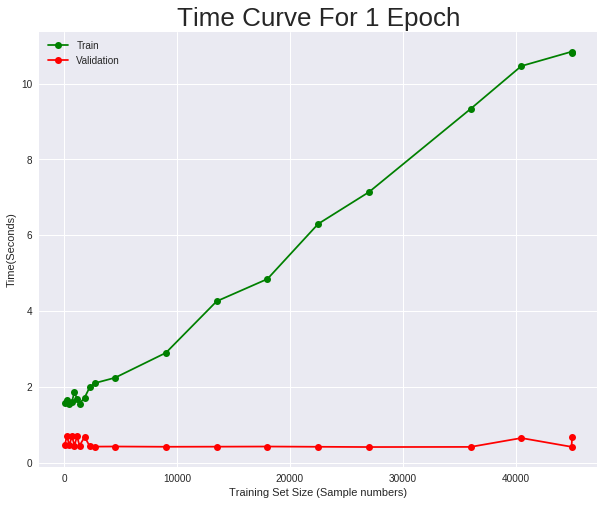

In [48]:
#Drawing train/val time v.s. training set for 1 epoch

plt.figure(figsize = (10,8))
plt.plot(Train_size_list_1ep, Train_time_list_1ep, 'go-', label = "Train")
plt.plot(Train_size_list_1ep, Val_time_list_1ep, 'ro-', label = "Validation")
plt.xlabel('Training Set Size (Sample numbers)')
plt.ylabel('Time(Seconds)')
plt.title('Time Curve For 1 Epoch', fontsize=26)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)
plt.savefig('./TimeCurve_1ep.png')

In [53]:
# Saving data locally
import os
print( os.getcwd() )
print( os.listdir(os.getcwd()) )
print( os.listdir('models') )

/content
['sample_data', '.config', 'TimeCurve_1ep.png', 'models', 'LearningCurve_1ep.png']
['dnn_clf_1ep']


In [0]:
#downloading relevent files
from google.colab import files
#files.download( "./models/dnn_clf_1ep" )
#files.download( "./TimeCurve_1ep.png" )
#files.download( "./LearningCurve_1ep.png" )